In [1]:
import gym
import random, math
import numpy as np
import arcade
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

        
from LightEnvCopy import LightEnv

import gym.spaces
from gym.spaces import Discrete, Box

from ray.rllib.env.env_context import EnvContext
from ray.rllib.models import ModelCatalog

from collections import namedtuple

# Do the math to figure out our screen dimensions
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 600
SCREEN_TITLE = "Game 2: Let There Be Light!"

# COnvenient data structure to hold information about actions
Action = namedtuple('Action', 'name index delta_i delta_j')

up = Action('up', 0, -1, 0)    
down = Action('down', 1, 1, 0)    
left = Action('left', 2, 0, -1)    
right = Action('right', 3, 0, 1)    

index_to_actions = {}
for action in [up, down, left, right]:
    index_to_actions[action.index] = action
# print(index_to_actions[0].name)
str_to_actions = {}
for action in [up, down, left, right]:
    str_to_actions[action.name] = action
#TF End - Adding in actions for action conversion


class LightEnvWrapper(gym.Env, LightEnv):
    """Class that wraps the Lights Environment to make it 
    compatible with RLLib."""

    metadata = {"render.modes": ["rgb_array", "state_pixels"]}
    
    def __init__(self, config: EnvContext):
        super().__init__(SCREEN_WIDTH, SCREEN_HEIGHT, SCREEN_TITLE)
        self.torch_collected = False
        self.torch_collected_count = []
        self.mygame = LightEnv
        self.steps_taken = 0
        #The action space is a choice of 4 actions: U/D/L/R.
        self.action_space = Discrete(4)
        
        #The observation space is a fixed image of the current game screen
        self.observation_space = Box(low=0, high=255, shape=(84,84, 4), dtype=np.uint8)
        
    def reset(self):
        print("resetting in wrapper")
        
        if self.torch_collected == 1:
            print("Torch was collected this episode!")
        else:
            print("Torch was not collected this episode...")
        self.torch_collected_count.append(self.torch_collected)
        print(self.torch_collected_count)

        self.render(self)
        #Resets the state of the environment for a new episode and an initial observation.
        obs_mygame = self.mygame.reset(self)
        
        #Open up the resetted image to verify working correctly.
        obs_mygame.show()
        
        self.mygame.on_draw(self)
        #Convert observation to 84x84 resolution and np array for rllib.
        obs = self.convert_observations(obs_mygame)
        
        self.steps_taken = 0
        return obs

    def step(self, action):
        self.steps_taken += 1
        
        #Making sure an action is chosen, either: 0, 1, 2, 3.
        assert action in [0, 1, 2, 3] #0-up,1-down,2-left,3-right.
        
        #Convert the numeric action to a keyword: up, down, left, right.
        actions_myenv = index_to_actions[action].name #returns a word, one of: up/down/left/right
#         print(f"action taken: {actions_myenv}")
        
        #Update the window with on_update()
        self.render(self)
#         print("env rendered")
        #Compute observation extracted from the window (800x600), with reward and done flag.
        obs, reward, done, torch_collected = self.mygame.step(self,actions_myenv)
        if torch_collected == True:
            self.torch_collected = 1
        else:
            self.torch_collected = 0
                    
        if self.steps_taken % 100 == 0: #33 steps roughly equates to 1 second in game time
            print(f"total score is {self.score} at time: {self.mygame.time_taken_reported(self)}")
            print(f"steps taken: {self.steps_taken}")
#             print(f"FPS is currently: {fps_check}")
        #Convert observation to 84x84 resolution and np array for rllib.
        obs_mygame = self.convert_observations(obs)
        
        #If the reward has been obtained, reset the environment and start again
        if done == True:
            print(f"done is {done}, resetting environment in wrapper.")
            print(f"steps taken: {self.steps_taken}")
            obs.show()
            self.reset()
        
        return obs_mygame, reward, done, {}

    def seed(self, seed=None):
        random.seed(seed)

    def convert_observations(self, obs_mygame): #resizing and converting to array for rllib processing
        # We normalize and concatenate observations
        obs = obs_mygame
        obs_resized = obs.resize((84,84))
        obsarray = np.array(obs_resized)
        return obsarray
    
    def render(self, mode='state_pixels'):
#         self.mygame.update(self)
        self.mygame.on_draw(self)
        test = self.mygame.time_taken_reported(self)
        

C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\tensorflow_probability\python\__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


### Now run the rllib script to train the agent

### Manual Grid Search

#### lr

In [2]:
import gym
import ray.rllib.agents.ppo.ppo as ppo
from ray.rllib.algorithms.ppo import PPOConfig
from ray import air
from ray import tune
import os


config = PPOConfig()


from ray.rllib.algorithms.ppo import PPOConfig
RAY_DISABLE_MEMORY_MONITOR = 1
config = PPOConfig().training(gamma=0.99, lr=0.001, kl_coeff=0.2, entropy_coeff=1,
#                               entropy_coeff_schedule=[[0,1],[1000,0]],
                             sgd_minibatch_size=128, num_sgd_iter=60)\
            .resources(num_gpus=0)\
            .rollouts(num_envs_per_worker=1, num_rollout_workers=2, recreate_failed_workers=True, horizon=30000)
config.normalize_actions=False
config.env=LightEnvWrapper
config.clip_actions=False
print(config.to_dict())
# Build a Algorithm object from the config
trainer = ppo.PPOTrainer(config=config)

avg_rewards = []
num_iterations = []
for episode in range(100):
    print("Starting episode ", episode)
    # Perform one iteration of training the policy with PPO
    result = trainer.train()
    #print(pretty_print(result))
    print("episode reward mean: ", result['episode_reward_mean'])
    avg_rewards.append(result['episode_reward_mean'])
    num_iterations.append(episode)
    if episode % 10 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)
    print("End of episode ", episode)



    

{'extra_python_environs_for_driver': {}, 'extra_python_environs_for_worker': {}, 'num_gpus': 0, 'num_cpus_per_worker': 1, 'num_gpus_per_worker': 0, '_fake_gpus': False, 'custom_resources_per_worker': {}, 'placement_strategy': 'PACK', 'eager_tracing': False, 'eager_max_retraces': 20, 'tf_session_args': {'intra_op_parallelism_threads': 2, 'inter_op_parallelism_threads': 2, 'gpu_options': {'allow_growth': True}, 'log_device_placement': False, 'device_count': {'CPU': 1}, 'allow_soft_placement': True}, 'local_tf_session_args': {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8}, 'env': <class '__main__.LightEnvWrapper'>, 'env_config': {}, 'observation_space': None, 'action_space': None, 'env_task_fn': None, 'render_env': False, 'clip_rewards': None, 'normalize_actions': False, 'clip_actions': False, 'disable_env_checking': False, 'num_workers': 2, 'num_envs_per_worker': 1, 'sample_collector': <class 'ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCollecto

C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
2022-09-27 21:46:37,332	INFO worker.py:1518 -- Started a local Ray instance.
(pid=21952) Windows fatal exception: code 0xc0000139
(pid=21952) 
(pid=5152) Windows fatal exception: code 0xc0000139
(pid=5152) 
(pid=21952) C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\tensorflow_probability\python\__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(pid=21952)   if (distutils.version.LooseVersion(tf.__version__) <
(pid=5152) C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\tensorflow_probability\pyth

(RolloutWorker pid=21952) resetting in wrapper
(RolloutWorker pid=21952) Torch was not collected this episode...
(RolloutWorker pid=21952) [False]
(RolloutWorker pid=5152) resetting in wrapper
(RolloutWorker pid=5152) Torch was not collected this episode...
(RolloutWorker pid=5152) [False]
(RolloutWorker pid=21952) resetting
(RolloutWorker pid=5152) resetting


2022-09-27 21:47:01,755	INFO trainable.py:160 -- Trainable.setup took 29.034 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-09-27 21:47:01,758	WARNING util.py:65 -- Install gputil for GPU system monitoring.


Starting episode  0
(RolloutWorker pid=21952) resetting in wrapper
(RolloutWorker pid=21952) Torch was not collected this episode...
(RolloutWorker pid=21952) [False, 0]
(RolloutWorker pid=21952) resetting
(RolloutWorker pid=5152) resetting in wrapper
(RolloutWorker pid=5152) Torch was not collected this episode...
(RolloutWorker pid=5152) [False, 0]
(RolloutWorker pid=5152) resetting
(RolloutWorker pid=5152) total score is -4 at time: 2
(RolloutWorker pid=5152) FPS is currently: 88
(RolloutWorker pid=21952) total score is -4 at time: 2
(RolloutWorker pid=21952) FPS is currently: 80
(RolloutWorker pid=5152) total score is -5 at time: 3
(RolloutWorker pid=5152) FPS is currently: 93
(RolloutWorker pid=21952) total score is -5 at time: 3
(RolloutWorker pid=21952) FPS is currently: 91
(RolloutWorker pid=5152) total score is -7 at time: 5
(RolloutWorker pid=5152) FPS is currently: 82
(RolloutWorker pid=21952) total score is -7 at time: 5
(RolloutWorker pid=21952) FPS is currently: 80
(Rollo

2022-09-27 21:47:39,567	ERROR algorithm.py:2173 -- Error in training or evaluation attempt! Trying to recover.
Traceback (most recent call last):
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\algorithm.py", line 2373, in _run_one_training_iteration
    results = self.training_step()
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\ppo\ppo.py", line 407, in training_step
    train_batch = synchronous_parallel_sample(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\execution\rollout_ops.py", line 100, in synchronous_parallel_sample
    sample_batches = ray.get(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\worker.py", line 2275, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RayOutOfMemoryError): ray::

2022-09-27 21:47:41,286	ERROR worker_set.py:728 -- Worker 2 is faulty.
Traceback (most recent call last):
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\algorithm.py", line 2373, in _run_one_training_iteration
    results = self.training_step()
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\ppo\ppo.py", line 407, in training_step
    train_batch = synchronous_parallel_sample(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\execution\rollout_ops.py", line 100, in synchronous_parallel_sample
    sample_batches = ray.get(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\worker.py", line 2275, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RayOutOfMemoryError): ray::RolloutWorker.sample() (pid=21952, ip=12

(pid=940) Windows fatal exception: code 0xc0000139
(pid=940) 
(pid=27112) Windows fatal exception: code 0xc0000139
(pid=27112) 
(pid=940) C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\tensorflow_probability\python\__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(pid=940)   if (distutils.version.LooseVersion(tf.__version__) <
(pid=27112) C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\tensorflow_probability\python\__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(pid=27112)   if (distutils.version.LooseVersion(tf.__version__) <
(RolloutWorker pid=27112) 2022-09-27 21:47:55,629	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


(RolloutWorker pid=940) resetting in wrapper
(RolloutWorker pid=940) Torch was not collected this episode...
(RolloutWorker pid=940) [False]
(RolloutWorker pid=27112) resetting in wrapper
(RolloutWorker pid=27112) Torch was not collected this episode...
(RolloutWorker pid=27112) [False]
(RolloutWorker pid=940) resetting
(RolloutWorker pid=27112) resetting
(RolloutWorker pid=27112) resetting in wrapper
(RolloutWorker pid=27112) Torch was not collected this episode...
(RolloutWorker pid=27112) [False, 0]
(RolloutWorker pid=27112) resetting
(RolloutWorker pid=940) resetting in wrapper
(RolloutWorker pid=940) Torch was not collected this episode...
(RolloutWorker pid=940) [False, 0]
(RolloutWorker pid=940) resetting
(RolloutWorker pid=27112) Game completed with a score of: 99 at time: 0
(RolloutWorker pid=27112) done is True, resetting environment in wrapper.
(RolloutWorker pid=27112) steps taken: 29
(RolloutWorker pid=27112) resetting in wrapper
(RolloutWorker pid=27112) Torch was not col

2022-09-27 21:48:30,411	ERROR algorithm.py:2173 -- Error in training or evaluation attempt! Trying to recover.
Traceback (most recent call last):
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\algorithm.py", line 2373, in _run_one_training_iteration
    results = self.training_step()
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\ppo\ppo.py", line 407, in training_step
    train_batch = synchronous_parallel_sample(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\execution\rollout_ops.py", line 100, in synchronous_parallel_sample
    sample_batches = ray.get(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\worker.py", line 2275, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RayOutOfMemoryError): ray::

(RolloutWorker pid=27112) total score is -13 at time: 13
(RolloutWorker pid=27112) FPS is currently: 78
(RolloutWorker pid=27112) total score is -15 at time: 15
(RolloutWorker pid=27112) FPS is currently: 82
(RolloutWorker pid=940) total score is -15 at time: 15
(RolloutWorker pid=940) FPS is currently: 57


2022-09-27 21:48:36,096	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.sample() (pid=940, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000015EF643CF40>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
27112	0.77GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
17236	0.44GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
940	0.41GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
29420	0.29GiB	C:\Program Files 

(RolloutWorker pid=940) total score is -17 at time: 17
(RolloutWorker pid=940) FPS is currently: 72
(RolloutWorker pid=27112) total score is -17 at time: 17
(RolloutWorker pid=27112) FPS is currently: 102
(RolloutWorker pid=27112) total score is -18 at time: 18
(RolloutWorker pid=27112) FPS is currently: 89
(RolloutWorker pid=940) total score is -18 at time: 18
(RolloutWorker pid=940) FPS is currently: 65
(RolloutWorker pid=940) total score is -20 at time: 20
(RolloutWorker pid=940) FPS is currently: 67
(RolloutWorker pid=27112) total score is -20 at time: 20
(RolloutWorker pid=27112) FPS is currently: 72
(RolloutWorker pid=27112) total score is -22 at time: 22
(RolloutWorker pid=27112) FPS is currently: 77
(RolloutWorker pid=940) total score is -22 at time: 22
(RolloutWorker pid=940) FPS is currently: 55
(RolloutWorker pid=940) total score is -23 at time: 23
(RolloutWorker pid=940) FPS is currently: 68
(RolloutWorker pid=27112) total score is -23 at time: 23
(RolloutWorker pid=27112) 

2022-09-27 21:49:16,118	ERROR algorithm.py:2173 -- Error in training or evaluation attempt! Trying to recover.
Traceback (most recent call last):
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\algorithm.py", line 2373, in _run_one_training_iteration
    results = self.training_step()
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\ppo\ppo.py", line 407, in training_step
    train_batch = synchronous_parallel_sample(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\execution\rollout_ops.py", line 100, in synchronous_parallel_sample
    sample_batches = ray.get(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\worker.py", line 2275, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RayOutOfMemoryError): ray::

(RolloutWorker pid=27112) total score is -37 at time: 37
(RolloutWorker pid=27112) FPS is currently: 100
(RolloutWorker pid=27112) total score is -38 at time: 38
(RolloutWorker pid=27112) FPS is currently: 71
(RolloutWorker pid=940) total score is -38 at time: 38
(RolloutWorker pid=940) FPS is currently: 64


2022-09-27 21:49:21,486	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.sample() (pid=940, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000015EF643CF40>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.37 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
27112	0.75GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
17236	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
940	0.41GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
29420	0.28GiB	C:\Program Files 

(RolloutWorker pid=940) total score is -40 at time: 40
(RolloutWorker pid=940) FPS is currently: 67
(RolloutWorker pid=27112) total score is -40 at time: 40
(RolloutWorker pid=27112) FPS is currently: 93
(RolloutWorker pid=940) total score is -42 at time: 42
(RolloutWorker pid=940) FPS is currently: 90
(RolloutWorker pid=27112) total score is -42 at time: 42
(RolloutWorker pid=27112) FPS is currently: 88
(RolloutWorker pid=940) total score is -43 at time: 43
(RolloutWorker pid=940) FPS is currently: 59
(RolloutWorker pid=27112) total score is -43 at time: 43
(RolloutWorker pid=27112) FPS is currently: 80
(RolloutWorker pid=940) total score is -45 at time: 45
(RolloutWorker pid=940) FPS is currently: 72
(RolloutWorker pid=27112) total score is -45 at time: 45
(RolloutWorker pid=27112) FPS is currently: 81
(RolloutWorker pid=940) total score is -47 at time: 47
(RolloutWorker pid=940) FPS is currently: 62
(RolloutWorker pid=27112) total score is -47 at time: 47
(RolloutWorker pid=27112) F

(RolloutWorker pid=27112) total score is -104 at time: 92
(RolloutWorker pid=27112) FPS is currently: 83
(RolloutWorker pid=940) total score is -105 at time: 93
(RolloutWorker pid=940) FPS is currently: 87
(RolloutWorker pid=27112) total score is -105 at time: 93
(RolloutWorker pid=27112) FPS is currently: 85
(RolloutWorker pid=940) total score is -108 at time: 95
(RolloutWorker pid=940) FPS is currently: 85
(RolloutWorker pid=27112) total score is -108 at time: 95
(RolloutWorker pid=27112) FPS is currently: 90
(RolloutWorker pid=940) total score is -110 at time: 97
(RolloutWorker pid=940) FPS is currently: 81
(RolloutWorker pid=27112) total score is -111 at time: 97
(RolloutWorker pid=27112) FPS is currently: 95
(RolloutWorker pid=940) total score is -111 at time: 98
(RolloutWorker pid=940) FPS is currently: 88
(RolloutWorker pid=27112) total score is -112 at time: 98
(RolloutWorker pid=27112) FPS is currently: 81
(RolloutWorker pid=940) total score is -115 at time: 100
(RolloutWorker

(RolloutWorker pid=940) total score is -168 at time: 145
(RolloutWorker pid=940) FPS is currently: 95
(RolloutWorker pid=27112) total score is -165 at time: 145
(RolloutWorker pid=27112) FPS is currently: 89
(RolloutWorker pid=940) total score is -170 at time: 147
(RolloutWorker pid=940) FPS is currently: 85
(RolloutWorker pid=27112) total score is -167 at time: 147
(RolloutWorker pid=27112) FPS is currently: 85
(RolloutWorker pid=940) total score is -173 at time: 148
(RolloutWorker pid=940) FPS is currently: 75
(RolloutWorker pid=27112) total score is -168 at time: 148
(RolloutWorker pid=27112) FPS is currently: 74
(RolloutWorker pid=940) total score is -175 at time: 150
(RolloutWorker pid=940) FPS is currently: 70
(RolloutWorker pid=27112) total score is -170 at time: 150
(RolloutWorker pid=27112) FPS is currently: 79
(RolloutWorker pid=940) total score is -177 at time: 152
(RolloutWorker pid=940) FPS is currently: 72
(RolloutWorker pid=27112) total score is -173 at time: 152
(Rollou

(RolloutWorker pid=27112) total score is -225 at time: 197
(RolloutWorker pid=27112) FPS is currently: 89
(RolloutWorker pid=940) total score is -228 at time: 198
(RolloutWorker pid=940) FPS is currently: 81
(RolloutWorker pid=27112) total score is -226 at time: 198
(RolloutWorker pid=27112) FPS is currently: 87
(RolloutWorker pid=940) total score is -230 at time: 200
(RolloutWorker pid=940) FPS is currently: 83
(RolloutWorker pid=27112) total score is -228 at time: 200
(RolloutWorker pid=27112) FPS is currently: 87
(RolloutWorker pid=940) total score is -232 at time: 202
(RolloutWorker pid=940) FPS is currently: 66
(RolloutWorker pid=27112) total score is -230 at time: 202
(RolloutWorker pid=27112) FPS is currently: 68
(RolloutWorker pid=940) total score is -233 at time: 203
(RolloutWorker pid=940) FPS is currently: 74
(RolloutWorker pid=27112) total score is -231 at time: 203
(RolloutWorker pid=27112) FPS is currently: 53
(RolloutWorker pid=940) total score is -235 at time: 205
(Roll

(RolloutWorker pid=27112) total score is -280 at time: 248
(RolloutWorker pid=27112) FPS is currently: 97
(RolloutWorker pid=940) total score is -282 at time: 250
(RolloutWorker pid=940) FPS is currently: 83
(RolloutWorker pid=27112) total score is -282 at time: 250
(RolloutWorker pid=27112) FPS is currently: 82
(RolloutWorker pid=940) total score is -285 at time: 252
(RolloutWorker pid=940) FPS is currently: 83
(RolloutWorker pid=27112) total score is -284 at time: 252
(RolloutWorker pid=27112) FPS is currently: 93
(RolloutWorker pid=940) total score is -286 at time: 253
(RolloutWorker pid=940) FPS is currently: 83
(RolloutWorker pid=27112) total score is -285 at time: 253
(RolloutWorker pid=27112) FPS is currently: 90
(RolloutWorker pid=940) total score is -288 at time: 255
(RolloutWorker pid=940) FPS is currently: 85
(RolloutWorker pid=27112) total score is -287 at time: 255
(RolloutWorker pid=27112) FPS is currently: 89
(RolloutWorker pid=940) total score is -291 at time: 257
(Roll

(RolloutWorker pid=940) total score is -336 at time: 302
(RolloutWorker pid=940) FPS is currently: 77
(RolloutWorker pid=27112) total score is -334 at time: 302
(RolloutWorker pid=27112) FPS is currently: 89
(RolloutWorker pid=940) total score is -337 at time: 303
(RolloutWorker pid=940) FPS is currently: 87
(RolloutWorker pid=27112) total score is -335 at time: 303
(RolloutWorker pid=27112) FPS is currently: 85
(RolloutWorker pid=940) total score is -339 at time: 305
(RolloutWorker pid=940) FPS is currently: 94
(RolloutWorker pid=27112) total score is -337 at time: 305
(RolloutWorker pid=27112) FPS is currently: 95
(RolloutWorker pid=940) total score is -341 at time: 307
(RolloutWorker pid=940) FPS is currently: 83
episode reward mean:  99.0
End of episode  7
Starting episode  8
(RolloutWorker pid=27112) total score is -339 at time: 307
(RolloutWorker pid=27112) FPS is currently: 115
(RolloutWorker pid=940) total score is -342 at time: 308
(RolloutWorker pid=940) FPS is currently: 111

(RolloutWorker pid=940) total score is -391 at time: 353
(RolloutWorker pid=940) FPS is currently: 79
(RolloutWorker pid=27112) total score is -386 at time: 353
(RolloutWorker pid=27112) FPS is currently: 80
(RolloutWorker pid=940) total score is -394 at time: 355
(RolloutWorker pid=940) FPS is currently: 90
(RolloutWorker pid=27112) total score is -388 at time: 355
(RolloutWorker pid=27112) FPS is currently: 91
(RolloutWorker pid=940) total score is -396 at time: 357
(RolloutWorker pid=940) FPS is currently: 81
(RolloutWorker pid=27112) total score is -390 at time: 357
(RolloutWorker pid=27112) FPS is currently: 81
(RolloutWorker pid=940) total score is -397 at time: 358
(RolloutWorker pid=940) FPS is currently: 85
(RolloutWorker pid=27112) total score is -391 at time: 358
(RolloutWorker pid=27112) FPS is currently: 93
(RolloutWorker pid=940) total score is -399 at time: 360
(RolloutWorker pid=940) FPS is currently: 83
(RolloutWorker pid=27112) total score is -393 at time: 360
(Rollou

(RolloutWorker pid=27112) total score is -436 at time: 402
(RolloutWorker pid=27112) FPS is currently: 68
(RolloutWorker pid=940) resetting in wrapper
(RolloutWorker pid=940) Torch was not collected this episode...
(RolloutWorker pid=940) [False, 0, 0, False]
(RolloutWorker pid=940) resetting
(RolloutWorker pid=940) total score is -6 at time: 2
(RolloutWorker pid=940) FPS is currently: 88
(RolloutWorker pid=27112) total score is -438 at time: 403
(RolloutWorker pid=27112) FPS is currently: 76
(RolloutWorker pid=940) total score is -7 at time: 3
(RolloutWorker pid=940) FPS is currently: 72
(RolloutWorker pid=27112) total score is -440 at time: 405
(RolloutWorker pid=27112) FPS is currently: 79
episode reward mean:  -121.0
checkpoint saved at C:\Users\Tim/ray_results\PPO_LightEnvWrapper_2022-09-27_21-46-32itz4gpn9\checkpoint_000011
End of episode  10
Starting episode  11
(RolloutWorker pid=940) total score is -9 at time: 5
(RolloutWorker pid=940) FPS is currently: 98
(RolloutWorker pid=2

(RolloutWorker pid=27112) total score is -489 at time: 452
(RolloutWorker pid=27112) FPS is currently: 87
(RolloutWorker pid=940) total score is -64 at time: 52
(RolloutWorker pid=940) FPS is currently: 69
(RolloutWorker pid=27112) total score is -490 at time: 453
(RolloutWorker pid=27112) FPS is currently: 94
(RolloutWorker pid=940) total score is -65 at time: 53
(RolloutWorker pid=940) FPS is currently: 69
(RolloutWorker pid=27112) total score is -492 at time: 455
(RolloutWorker pid=27112) FPS is currently: 63
(RolloutWorker pid=940) total score is -67 at time: 55
(RolloutWorker pid=940) FPS is currently: 86
(RolloutWorker pid=27112) total score is -494 at time: 457
(RolloutWorker pid=27112) FPS is currently: 85
(RolloutWorker pid=940) total score is -69 at time: 57
(RolloutWorker pid=940) FPS is currently: 81
(RolloutWorker pid=27112) total score is -495 at time: 458
(RolloutWorker pid=27112) FPS is currently: 85
(RolloutWorker pid=940) total score is -70 at time: 58
(RolloutWorker 

(RolloutWorker pid=27112) total score is -538 at time: 500
(RolloutWorker pid=27112) FPS is currently: 109
(RolloutWorker pid=27112) resetting in wrapper
(RolloutWorker pid=27112) Torch was collected this episode!
(RolloutWorker pid=27112) [False, 0, 0, False, 1]
(RolloutWorker pid=27112) resetting
(RolloutWorker pid=940) total score is -8 at time: 3
(RolloutWorker pid=940) FPS is currently: 122
(RolloutWorker pid=27112) total score is -6 at time: 2
(RolloutWorker pid=27112) FPS is currently: 114
(RolloutWorker pid=940) total score is -11 at time: 5
(RolloutWorker pid=940) FPS is currently: 103
(RolloutWorker pid=27112) total score is -9 at time: 3
(RolloutWorker pid=27112) FPS is currently: 109
(RolloutWorker pid=940) total score is -15 at time: 7
(RolloutWorker pid=940) FPS is currently: 94
(RolloutWorker pid=27112) total score is -12 at time: 5
(RolloutWorker pid=27112) FPS is currently: 85
episode reward mean:  -197.75
End of episode  13
Starting episode  14
(RolloutWorker pid=940)

(RolloutWorker pid=940) total score is -74 at time: 53
(RolloutWorker pid=940) FPS is currently: 91
(RolloutWorker pid=27112) total score is -70 at time: 52
(RolloutWorker pid=27112) FPS is currently: 80
(RolloutWorker pid=940) total score is -76 at time: 55
(RolloutWorker pid=940) FPS is currently: 81
(RolloutWorker pid=27112) total score is -72 at time: 53
(RolloutWorker pid=27112) FPS is currently: 90
(RolloutWorker pid=940) total score is -78 at time: 57
(RolloutWorker pid=940) FPS is currently: 85
(RolloutWorker pid=27112) total score is -74 at time: 55
(RolloutWorker pid=27112) FPS is currently: 88
(RolloutWorker pid=940) total score is -79 at time: 58
(RolloutWorker pid=940) FPS is currently: 92
(RolloutWorker pid=27112) total score is -76 at time: 57
(RolloutWorker pid=27112) FPS is currently: 82
(RolloutWorker pid=940) total score is -81 at time: 60
(RolloutWorker pid=940) FPS is currently: 91
(RolloutWorker pid=27112) total score is -77 at time: 58
(RolloutWorker pid=27112) F

(RolloutWorker pid=27112) total score is -126 at time: 100
(RolloutWorker pid=27112) FPS is currently: 94
(RolloutWorker pid=940) total score is -40 at time: 33
(RolloutWorker pid=940) FPS is currently: 85
(RolloutWorker pid=27112) total score is -128 at time: 102
(RolloutWorker pid=27112) FPS is currently: 95
(RolloutWorker pid=940) total score is -42 at time: 35
(RolloutWorker pid=940) FPS is currently: 78
(RolloutWorker pid=27112) total score is -129 at time: 103
(RolloutWorker pid=27112) FPS is currently: 85
(RolloutWorker pid=940) total score is -45 at time: 37
(RolloutWorker pid=940) FPS is currently: 84
(RolloutWorker pid=27112) total score is -131 at time: 105
(RolloutWorker pid=27112) FPS is currently: 88
(RolloutWorker pid=940) total score is -46 at time: 38
(RolloutWorker pid=940) FPS is currently: 89
episode reward mean:  -156.2
End of episode  16
Starting episode  17
(RolloutWorker pid=27112) total score is -133 at time: 107
(RolloutWorker pid=27112) FPS is currently: 108


(RolloutWorker pid=940) total score is -97 at time: 85
(RolloutWorker pid=940) FPS is currently: 81
(RolloutWorker pid=27112) total score is -181 at time: 153
(RolloutWorker pid=27112) FPS is currently: 90
(RolloutWorker pid=940) total score is -99 at time: 87
(RolloutWorker pid=940) FPS is currently: 92
(RolloutWorker pid=27112) total score is -183 at time: 155
(RolloutWorker pid=27112) FPS is currently: 90
(RolloutWorker pid=940) total score is -100 at time: 88
(RolloutWorker pid=940) FPS is currently: 89
(RolloutWorker pid=27112) total score is -185 at time: 157
(RolloutWorker pid=27112) FPS is currently: 90
(RolloutWorker pid=940) total score is -102 at time: 90
(RolloutWorker pid=940) FPS is currently: 99
(RolloutWorker pid=27112) total score is -186 at time: 158
(RolloutWorker pid=27112) FPS is currently: 93
(RolloutWorker pid=940) total score is -104 at time: 92
(RolloutWorker pid=940) FPS is currently: 78
(RolloutWorker pid=27112) total score is -188 at time: 160
(RolloutWorker

(RolloutWorker pid=27112) total score is -237 at time: 205
(RolloutWorker pid=27112) FPS is currently: 97
(RolloutWorker pid=940) total score is -154 at time: 138
(RolloutWorker pid=940) FPS is currently: 81
episode reward mean:  -156.2
End of episode  19
Starting episode  20
(RolloutWorker pid=27112) total score is -239 at time: 207
(RolloutWorker pid=27112) FPS is currently: 111
(RolloutWorker pid=940) total score is -156 at time: 140
(RolloutWorker pid=940) FPS is currently: 115
(RolloutWorker pid=27112) total score is -240 at time: 208
(RolloutWorker pid=27112) FPS is currently: 111
(RolloutWorker pid=940) total score is -159 at time: 142
(RolloutWorker pid=940) FPS is currently: 110
(RolloutWorker pid=27112) total score is -242 at time: 210
(RolloutWorker pid=27112) FPS is currently: 101
(RolloutWorker pid=940) total score is -160 at time: 143
(RolloutWorker pid=940) FPS is currently: 109
(RolloutWorker pid=27112) total score is -245 at time: 212
(RolloutWorker pid=27112) FPS is c

(RolloutWorker pid=940) total score is -211 at time: 188
(RolloutWorker pid=940) FPS is currently: 85
(RolloutWorker pid=27112) total score is -291 at time: 257
(RolloutWorker pid=27112) FPS is currently: 88
(RolloutWorker pid=940) total score is -213 at time: 190
(RolloutWorker pid=940) FPS is currently: 88
(RolloutWorker pid=27112) total score is -292 at time: 258
(RolloutWorker pid=27112) FPS is currently: 82
(RolloutWorker pid=940) total score is -215 at time: 192
(RolloutWorker pid=940) FPS is currently: 91
(RolloutWorker pid=27112) total score is -294 at time: 260
(RolloutWorker pid=27112) FPS is currently: 92
(RolloutWorker pid=940) total score is -216 at time: 193
(RolloutWorker pid=940) FPS is currently: 91
(RolloutWorker pid=27112) total score is -296 at time: 262
(RolloutWorker pid=27112) FPS is currently: 83
(RolloutWorker pid=940) total score is -218 at time: 195
(RolloutWorker pid=940) FPS is currently: 99
(RolloutWorker pid=27112) total score is -297 at time: 263
(Rollou

(RolloutWorker pid=940) total score is -266 at time: 240
(RolloutWorker pid=940) FPS is currently: 106
(RolloutWorker pid=27112) total score is -343 at time: 308
(RolloutWorker pid=27112) FPS is currently: 109
(RolloutWorker pid=940) total score is -268 at time: 242
(RolloutWorker pid=940) FPS is currently: 97
(RolloutWorker pid=27112) total score is -345 at time: 310
(RolloutWorker pid=27112) FPS is currently: 104
(RolloutWorker pid=940) total score is -269 at time: 243
(RolloutWorker pid=940) FPS is currently: 109
(RolloutWorker pid=27112) total score is -347 at time: 312
(RolloutWorker pid=27112) FPS is currently: 103
(RolloutWorker pid=940) total score is -271 at time: 245
(RolloutWorker pid=940) FPS is currently: 106
(RolloutWorker pid=27112) total score is -348 at time: 313
(RolloutWorker pid=27112) FPS is currently: 94
(RolloutWorker pid=940) total score is -273 at time: 247
(RolloutWorker pid=940) FPS is currently: 85
(RolloutWorker pid=27112) total score is -350 at time: 315
(

(RolloutWorker pid=27112) total score is -397 at time: 360
(RolloutWorker pid=27112) FPS is currently: 85
(RolloutWorker pid=940) total score is -322 at time: 293
(RolloutWorker pid=940) FPS is currently: 97
(RolloutWorker pid=27112) total score is -399 at time: 362
(RolloutWorker pid=27112) FPS is currently: 92
(RolloutWorker pid=940) total score is -324 at time: 295
(RolloutWorker pid=940) FPS is currently: 90
(RolloutWorker pid=27112) total score is -400 at time: 363
(RolloutWorker pid=27112) FPS is currently: 96
(RolloutWorker pid=940) total score is -326 at time: 297
(RolloutWorker pid=940) FPS is currently: 88
(RolloutWorker pid=27112) total score is -402 at time: 365
(RolloutWorker pid=27112) FPS is currently: 102
(RolloutWorker pid=940) total score is -327 at time: 298
(RolloutWorker pid=940) FPS is currently: 90
(RolloutWorker pid=27112) total score is -404 at time: 367
(RolloutWorker pid=27112) FPS is currently: 93
(RolloutWorker pid=940) total score is -329 at time: 300
(Rol

(RolloutWorker pid=27112) total score is -450 at time: 412
(RolloutWorker pid=27112) FPS is currently: 106
(RolloutWorker pid=940) total score is -378 at time: 345
(RolloutWorker pid=940) FPS is currently: 104
(RolloutWorker pid=27112) total score is -451 at time: 413
(RolloutWorker pid=27112) FPS is currently: 83
(RolloutWorker pid=940) total score is -380 at time: 347
(RolloutWorker pid=940) FPS is currently: 89
(RolloutWorker pid=27112) total score is -453 at time: 415
(RolloutWorker pid=27112) FPS is currently: 78
(RolloutWorker pid=940) total score is -381 at time: 348
(RolloutWorker pid=940) FPS is currently: 97
(RolloutWorker pid=27112) total score is -455 at time: 417
(RolloutWorker pid=27112) FPS is currently: 87
(RolloutWorker pid=940) total score is -383 at time: 350
(RolloutWorker pid=940) FPS is currently: 91
(RolloutWorker pid=27112) total score is -456 at time: 418
(RolloutWorker pid=27112) FPS is currently: 91
(RolloutWorker pid=940) total score is -385 at time: 352
(Ro

(RolloutWorker pid=27112) total score is -500 at time: 460
(RolloutWorker pid=27112) FPS is currently: 86
(RolloutWorker pid=940) total score is -37 at time: 27
(RolloutWorker pid=940) FPS is currently: 88
(RolloutWorker pid=27112) total score is -502 at time: 462
(RolloutWorker pid=27112) FPS is currently: 101
(RolloutWorker pid=940) total score is -39 at time: 28
(RolloutWorker pid=940) FPS is currently: 90
(RolloutWorker pid=27112) total score is -503 at time: 463
(RolloutWorker pid=27112) FPS is currently: 91
(RolloutWorker pid=940) total score is -42 at time: 30
(RolloutWorker pid=940) FPS is currently: 92
(RolloutWorker pid=27112) total score is -505 at time: 465
(RolloutWorker pid=27112) FPS is currently: 88
(RolloutWorker pid=940) total score is -44 at time: 32
(RolloutWorker pid=940) FPS is currently: 78
(RolloutWorker pid=27112) total score is -507 at time: 467
(RolloutWorker pid=27112) FPS is currently: 90
(RolloutWorker pid=940) total score is -46 at time: 33
(RolloutWorker

(RolloutWorker pid=27112) total score is -14 at time: 12
(RolloutWorker pid=27112) FPS is currently: 106
(RolloutWorker pid=940) total score is -95 at time: 78
(RolloutWorker pid=940) FPS is currently: 112
(RolloutWorker pid=27112) total score is -15 at time: 13
(RolloutWorker pid=27112) FPS is currently: 102
(RolloutWorker pid=940) total score is -97 at time: 80
(RolloutWorker pid=940) FPS is currently: 110
(RolloutWorker pid=27112) total score is -17 at time: 15
(RolloutWorker pid=27112) FPS is currently: 85
(RolloutWorker pid=940) total score is -99 at time: 82
(RolloutWorker pid=940) FPS is currently: 81
(RolloutWorker pid=27112) total score is -19 at time: 17
(RolloutWorker pid=27112) FPS is currently: 92
(RolloutWorker pid=940) total score is -101 at time: 83
(RolloutWorker pid=940) FPS is currently: 95
(RolloutWorker pid=27112) total score is -20 at time: 18
(RolloutWorker pid=27112) FPS is currently: 93
(RolloutWorker pid=940) total score is -103 at time: 85
(RolloutWorker pid=

(RolloutWorker pid=940) total score is -143 at time: 122
(RolloutWorker pid=940) FPS is currently: 91
(RolloutWorker pid=27112) total score is -27 at time: 20
(RolloutWorker pid=27112) FPS is currently: 99
(RolloutWorker pid=940) total score is -145 at time: 123
(RolloutWorker pid=940) FPS is currently: 81
(RolloutWorker pid=27112) total score is -30 at time: 22
(RolloutWorker pid=27112) FPS is currently: 85
(RolloutWorker pid=940) total score is -147 at time: 125
(RolloutWorker pid=940) FPS is currently: 95
(RolloutWorker pid=27112) total score is -31 at time: 23
(RolloutWorker pid=27112) FPS is currently: 87
(RolloutWorker pid=940) total score is -150 at time: 127
(RolloutWorker pid=940) FPS is currently: 83
(RolloutWorker pid=27112) total score is -33 at time: 25
(RolloutWorker pid=27112) FPS is currently: 92
(RolloutWorker pid=940) total score is -151 at time: 128
(RolloutWorker pid=940) FPS is currently: 97
(RolloutWorker pid=27112) total score is -35 at time: 27
(RolloutWorker pi

C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\policy\dynamic_tf_policy_v2.py:517: DeprecationWarning: invalid escape sequence \d
  mo = re.match("state_in_(\d+)", view_col)


KeyboardInterrupt: 

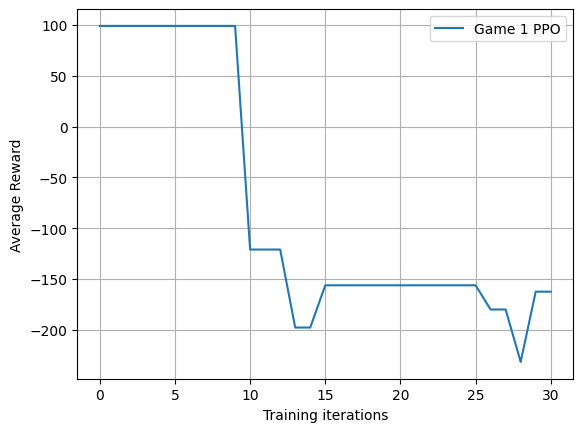

In [3]:
import matplotlib.pyplot as plt
plt.plot(num_iterations, avg_rewards, label="Game 1 PPO")   
plt.xlabel("Training iterations")
plt.ylabel("Average Reward")
plt.legend(loc=1)
plt.grid(True)
plt.show()